In [1]:
import os
import cv2
import mediapipe as mp
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Directory for storing data
DATA_DIR = "data"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [86]:
# Define activities and parameters
ACTIVITIES = ["Normal","Waving","Clapping","Calling","Standing","walking","Sitting","Dancing","Using Mobile"] #"standing", "walking", "waving"
NUM_CLASSES = len(ACTIVITIES)
SEQUENCE_LENGTH = 30  # Number of frames per sequence
FRAME_RATE = 3  # Collect data every nth frame

In [88]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils


In [90]:
# Function to collect data
def collect_data(activity_name):
    print(f"Collecting data for: {activity_name}")
    cap = cv2.VideoCapture(0)
    data = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error accessing the camera!")
            break

        frame = cv2.flip(frame, 1)
        results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks and frame_count % FRAME_RATE == 0:
            # Extract landmarks
            landmarks = [[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
            data.append(np.array(landmarks).flatten())

            # Draw landmarks on the frame
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        frame_count += 1
        cv2.putText(frame, f"Collecting: {activity_name}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Data Collection", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Save collected data
    data = np.array(data)
    np.save(os.path.join(DATA_DIR, f"{activity_name}.npy"), data)
    print(f"Data for {activity_name} saved with shape {data.shape}")

# Collect data for each activity
for activity in ACTIVITIES:
    collect_data(activity)


Data for Normal saved with shape (105, 99)
Data for Waving saved with shape (123, 99)
Data for Clapping saved with shape (106, 99)
Data for Calling saved with shape (113, 99)
Data for Standing saved with shape (136, 99)
Data for walking saved with shape (135, 99)
Data for Sitting saved with shape (106, 99)
Data for Dancing saved with shape (93, 99)
Data for Using Mobile saved with shape (152, 99)


In [92]:
# Load and preprocess data
def load_data():
    X, y = [], []
    for label, activity in enumerate(ACTIVITIES):
        data = np.load(os.path.join(DATA_DIR, f"{activity}.npy"))
        sequences = [data[i:i + SEQUENCE_LENGTH] for i in range(len(data) - SEQUENCE_LENGTH)]
        X.extend(sequences)
        y.extend([label] * len(sequences))
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = load_data()
print(f"Loaded data: X.shape={X.shape}, y.shape={y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

Loaded data: X.shape=(799, 30, 99), y.shape=(799,)


In [94]:
# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_train.shape[2])),
    LSTM(32),
    Dense(32, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())

# Train the model
callbacks = [EarlyStopping(monitor="val_loss", patience=5)]
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

C:\Users\prath\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,753 (217.79 KB)

 Trainable params: 55,753 (217.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.2112 - loss: 2.0684 - val_accuracy: 0.5312 - val_loss: 1.6000
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6480 - loss: 1.4509 - val_accuracy: 0.8938 - val_loss: 0.9354
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8616 - loss: 0.8181 - val_accuracy: 0.8562 - val_loss: 0.5731
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8806 - loss: 0.5344 - val_accuracy: 0.9250 - val_loss: 0.4059
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9236 - loss: 0.3795 - val_accuracy: 0.9625 - val_loss: 0.2641
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9151 - loss: 0.2928 - val_accuracy: 0.9375 - val_loss: 0.2731
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9194 - loss: 0.2700 - val_accuracy: 0.9625 - val_loss: 0.2077
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9847 - loss: 0.1460 - val_accuracy: 0.975

In [126]:
# Save the model
MODEL_PATH = "human_activity_recognition_model.h5"
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to human_activity_recognition_model.h5


In [132]:
import time


# Set the desired width and height for the camera window
DESIRED_WIDTH = 1020
DESIRED_HEIGHT = 720


# Real-time prediction with professional camera interface
def real_time_prediction():
    print("Starting real-time prediction...")
    model = load_model(MODEL_PATH)
    sequence = []  # Buffer to hold a sequence of frames
    cap = cv2.VideoCapture(0)

    # Initialize MediaPipe Pose and Face Detection
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    mp_drawing = mp.solutions.drawing_utils

    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Resize the frame to the desired size
        frame = cv2.resize(frame, (DESIRED_WIDTH, DESIRED_HEIGHT))

        # Process pose landmarks and face detection
        pose_results = pose.process(frame_rgb)
        face_results = face_detection.process(frame_rgb)

        if pose_results.pose_landmarks:
            # Extract pose landmarks
            landmarks = [[lm.x, lm.y, lm.z] for lm in pose_results.pose_landmarks.landmark]
            keypoints = np.array(landmarks).flatten()
            sequence.append(keypoints)

            # Maintain sequence length
            if len(sequence) > SEQUENCE_LENGTH:
                sequence.pop(0)

            # Predict activity if sequence is ready
            if len(sequence) == SEQUENCE_LENGTH:
                prediction = model.predict(np.expand_dims(sequence, axis=0))
                confidence = np.max(prediction)  # Get the confidence score
                activity = ACTIVITIES[np.argmax(prediction)]

                # Add a semi-transparent header for activity label
                overlay = frame.copy()
                cv2.rectangle(overlay, (0, 0), (frame.shape[1], 100), (0, 0, 0), -1)
                frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)

                # Display activity label
                label = f"Activity: {activity} ({confidence:.2f})"
                cv2.putText(frame, label, (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

            # Draw body bounding box
            body_landmarks = pose_results.pose_landmarks.landmark
            body_x = [lm.x for lm in body_landmarks]
            body_y = [lm.y for lm in body_landmarks]
            h, w, _ = frame.shape
            x_min = int(min(body_x) * w)
            x_max = int(max(body_x) * w)
            y_min = int(min(body_y) * h)
            y_max = int(max(body_y) * h)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        if face_results.detections:
            for detection in face_results.detections:
                # Get bounding box for the face
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = frame.shape
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
                x_max = x_min + box_width
                y_max = y_min + box_height

                # Draw face bounding box
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Draw border around the video feed
        border_color = (0, 255, 0)
        border_thickness = 5
        cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), border_color, border_thickness)

        # Add footer for instructions
        footer_overlay = frame.copy()
        cv2.rectangle(footer_overlay, (0, frame.shape[0] - 50), (frame.shape[1], frame.shape[0]), (0, 0, 0), -1)
        frame = cv2.addWeighted(footer_overlay, 0.6, frame, 0.4, 0)
        cv2.putText(frame, "Press 'Q' to Quit", (20, frame.shape[0] - 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Show video feed
        cv2.imshow("Professional Real-Time Prediction", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run enhanced real-time prediction
real_time_prediction()



Starting real-time prediction...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

In [69]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

# Save the history to a file for later use
history_dict = history.history
np.save("training_history.npy", history_dict)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9753 - loss: 0.0764 - val_accuracy: 0.9604 - val_loss: 0.1321
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9884 - loss: 0.0691 - val_accuracy: 0.9868 - val_loss: 0.0492
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9991 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0226
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9910 - loss: 0.0426 - val_accuracy: 1.0000 - val_loss: 0.0159
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9989 - loss: 0.0169 - val_accuracy: 0.9956 - val_loss: 0.0277
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9959 - loss: 0.0195 - val_accuracy: 0.9912 - val_loss: 0.0386
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9944 - loss: 0.0229 - val_accuracy: 0.9868 - val_loss: 0.0234
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9956 - loss: 0.0127 - val_accuracy: 1.0000 - v

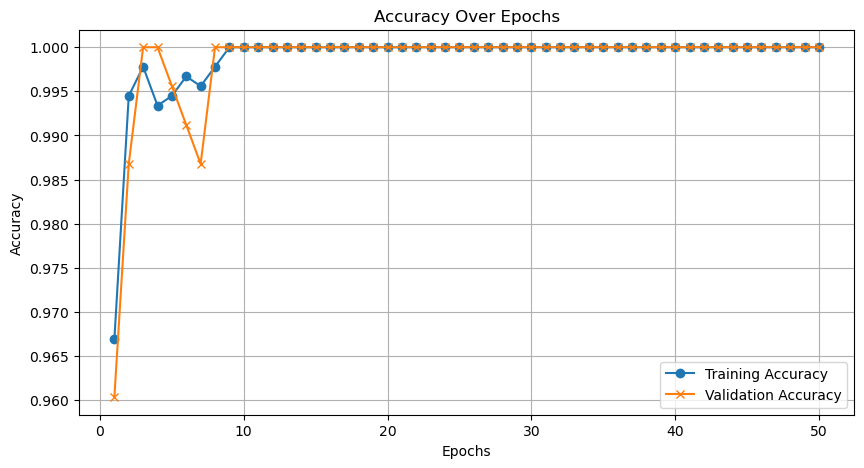

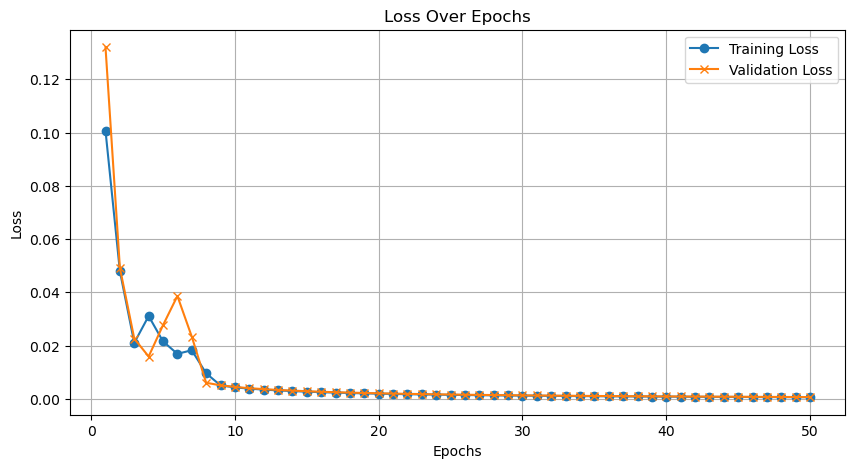

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


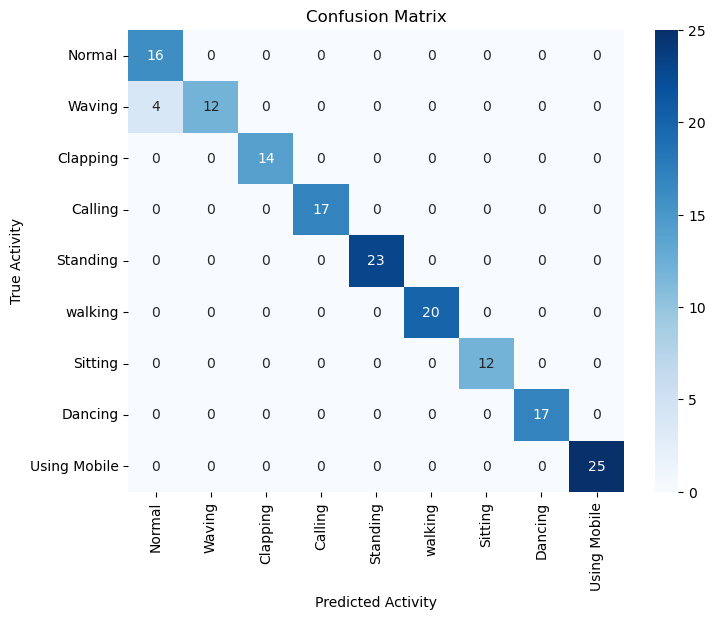

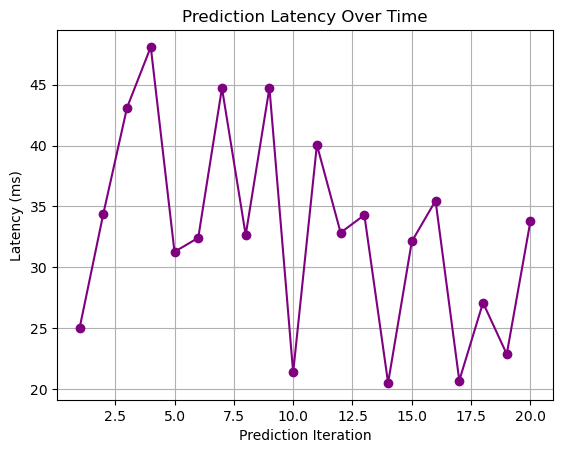

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load history data
history_dict = np.load('training_history.npy', allow_pickle=True).item()

# Accuracy and loss data
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# 1. Accuracy and Loss Trends (Line Charts)
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Training Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="x")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="x")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



# 2. Confusion Matrix (Heatmap)
true_labels = y_test.argmax(axis=1)  # Assuming y_test is one-hot encoded
pred_labels = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.show()



# 3. Real-Time Prediction Latency (Simulated)
iterations = np.arange(1, 21)  # Simulating 20 iterations of real-time predictions
latency = np.random.uniform(20, 50, size=20)  # Random latency values between 20-50ms for example

plt.plot(iterations, latency, marker="o", color="purple")
plt.title("Prediction Latency Over Time")
plt.xlabel("Prediction Iteration")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.show()




